# AutTextification competition

## Part 0: Exploratory Data Analysis

In [1]:
!pip install transformers
!pip install datasets
!pip install shap
!pip install lmppl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for lmppl: filename=lmppl-0.2.4-py3-none-any.whl size=12530 sha256=59ceb3abbacdda3bf3d9164de6f0e0e25eb1636b614258608ef28e3caafcb00e
  Stored in directory: /root/.cache/pip/wheels/52/1e/e9/6d11ce9e3f716ea26bde448f39a56603df5ec4f9aa957e7501
Successfully built lmppl
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which i

In [2]:
from nltk.corpus                     import stopwords
from datasets                        import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm                            import tqdm
from sklearn.metrics                 import accuracy_score, f1_score, precision_score, matthews_corrcoef, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection         import train_test_split
from transformers                    import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
import tensorflow                    as tf
import matplotlib.pyplot             as plt
import pandas                        as pd
import numpy                         as np
import scipy                         as sp
import torch
import shap
import spacy
import nltk
import glob

plt.style.use('ggplot')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
EN_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/en'
ES_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/es'

In [4]:
train_df_en = pd.read_csv('/kaggle/input/autextification/train_en.tsv', sep='\t')
train_df_en['lang'] = 'en'

train_df_es = pd.read_csv('/kaggle/input/autextification/train_es.tsv', sep='\t')
train_df_es['lang'] = 'es'

train_df = pd.concat([train_df_en, train_df_es])
train_df.reset_index(drop=True, inplace=True)
train_df['label'] = train_df['label'].apply(lambda x: 1 if x == 'generated' else 0)

## Train test split

In [5]:
train_df, test_df = train_test_split(train_df[['text', 'label']], test_size=0.2, random_state=42)

In [6]:
train_df = Dataset.from_pandas(train_df)
test_df  = Dataset.from_pandas(test_df)

In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
device    = "cuda" if torch.cuda.is_available() else "cpu"
# prepare los datos para el modelo
def prepare_data(data):
    text = data['text']
    label = data['label']
    tokenized_text = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    
    # Recorrer cada diccionario en la lista y aplicar 'to()' a cada tensor dentro del diccionario
    for key in tokenized_text:
        tokenized_text[key] = tokenized_text[key].to(device)
        
    return {
        'input_ids': tokenized_text['input_ids'].tolist(),
        'attention_mask': tokenized_text['attention_mask'].tolist(),
        'label': label,
    }

train_df = train_df.map(prepare_data, batched=True)
test_df = test_df.map(prepare_data, batched=True)

  0%|          | 0/53 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

## Load model

In [8]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [9]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy = 'epoch', # establecer la estrategia de guardado en 'epoch'
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=True
)


## Fit model

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=test_df,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'precision': precision_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'recall': recall_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'mcc': matthews_corrcoef(p.label_ids, p.predictions.argmax(axis=-1))
    },
)

__Uncased version__

In [12]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,0.241200,0.285933,0.886284,0.834660,0.964997,0.895109,0.782082
2,0.149700,0.267662,0.922773,0.897985,0.954888,0.925563,0.847210
3,0.079900,0.532292,0.898953,0.845511,0.977670,0.906801,0.807781


TrainOutput(global_step=9888, training_loss=0.18372267754718324, metrics={'train_runtime': 9501.2359, 'train_samples_per_second': 16.648, 'train_steps_per_second': 1.041, 'total_flos': 4.1617591181568e+16, 'train_loss': 0.18372267754718324, 'epoch': 3.0})

In [13]:
best_model_path = "/kaggle/working/bert_uncased_best_model.pth"
torch.save(trainer.model.state_dict(), best_model_path)

In [13]:
model.load_state_dict(torch.load("/kaggle/input/bert-uncased-model/bert_uncased_best_model.pth"))

<All keys matched successfully>

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=test_df,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'precision': precision_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'recall': recall_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'mcc': matthews_corrcoef(p.label_ids, p.predictions.argmax(axis=-1))
    }
)

In [22]:
with torch.no_grad():
    predictions, labels, metrics = trainer.predict(test_df, metric_key_prefix="predict")
    predictions = np.argmax(predictions, axis=1)

### Confussion Matrix

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


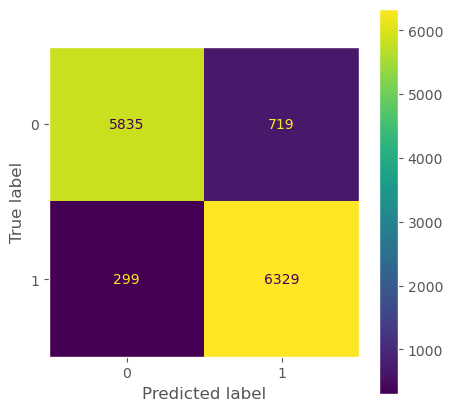

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
cm = confusion_matrix(test_df['label'], predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

disp.plot(ax=ax)
plt.grid(b=None)
plt.show()

__Cased version__

In [11]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,0.248100,0.256933,0.897739,0.861050,0.949909,0.903300,0.799676
2,0.152100,0.260812,0.927098,0.916385,0.940857,0.928460,0.854477
3,0.066600,0.542181,0.899332,0.845252,0.979028,0.907235,0.808807


TrainOutput(global_step=9888, training_loss=0.18220140671652885, metrics={'train_runtime': 9777.6677, 'train_samples_per_second': 16.177, 'train_steps_per_second': 1.011, 'total_flos': 4.1617591181568e+16, 'train_loss': 0.18220140671652885, 'epoch': 3.0})

In [12]:
best_model_path = "/kaggle/working/bert_cased_best_model.pth"
torch.save(trainer.model.state_dict(), best_model_path)

In [13]:
with torch.no_grad():
    predictions, labels, metrics = trainer.predict(test_df, metric_key_prefix="predict")
    predictions = np.argmax(predictions, axis=1)

### Confussion Matrix

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


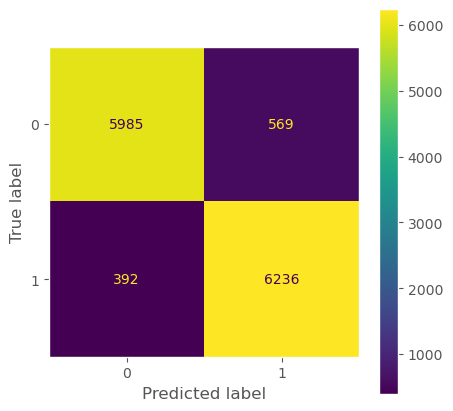

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
cm = confusion_matrix(test_df['label'], predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

disp.plot(ax=ax)
plt.grid(b=None)
plt.show()

In [23]:
test_df.to_csv('predictions.csv', index=False)

## Shap values

In [ ]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = trainer.model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
shap_values = explainer(test_df[:50], fixed_context=1)

In [20]:
# plot the first sentence's explanation
shap.plots.text(shap_values[48])

In [22]:
# plot the first sentence's explanation
shap.plots.text(shap_values[49])

In [23]:
# plot the first sentence's explanation
shap.plots.text(shap_values[45])